# Exploratory Data Analysis I

### Data in question
We are gracefully blessed with retail sales historical data for 45 Walmart stores in different regions. We are provided with 4 data files. 
1. Stores
    - This file contains information (like type and size) for each of the 45 stores 
2. Features
    - This file contains additional information related to the store, department and regional activity for the given dates
3. Test and Train data sets
    - Pretty self explanatory. We will used the train to fit the model and the test to test it :)

### Preliminary questions we would like to answer:

- What months of the year do we see the most sales?
- What regions showed higher sales during holidays?
- How did different holidays affect sales?
- What are the effects of markdowns on the sales?
- What regions showed to be more "sensitive" to markdowns?


 

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
train = pd.read_csv("train.csv")

In [4]:
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
train['Date'].max()

'2012-10-26'

In [6]:
train['Date'].min()

'2010-02-05'

The train file is simply 5 fields, one of which is a date and another that is a categorical value. The test file will have the same exact format minus the weekly sales, given that is what we will try to predict. 

### Let's see what the pther two data files look like

In [7]:
stores = pd.read_csv('stores.csv')
features = pd.read_csv('features.csv')

In [8]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [9]:
stores.Store.nunique()

45

The stores data contains information on size and store type for each of the 45 stores in question. We can join this to our original train data set to do some exploration.

In [10]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [11]:
features.tail()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False
8189,45,2013-07-26,76.06,3.804,212.02,851.73,2.06,10.88,1864.57,NaN,NaN,False


We don't have any documentation on the units of the fields. Temperature seems to be measured in degrees Farenheit (since these temperatures would be ridiculous if they were measured in Kelvin or Celsius). Fuel price will be assumed to be in US Dollars. CPI and Unemployment are both indeces, therefore they do not have untis. Finally, the Markdown fields are very cryptic. This could mean Markdown price of different items, the actual discounted amount, amount discounted per department... Let's keep exploring

In [12]:
features.Date.nunique()

182

In [14]:
gb1 = features.groupby('Store').agg({'Date': pd.Series.nunique})
print(gb1)

       Date
Store      
1       182
2       182
3       182
4       182
5       182
6       182
7       182
8       182
9       182
10      182
11      182
12      182
13      182
14      182
15      182
16      182
17      182
18      182
19      182
20      182
21      182
22      182
23      182
24      182
25      182
26      182
27      182
28      182
29      182
30      182
31      182
32      182
33      182
34      182
35      182
36      182
37      182
38      182
39      182
40      182
41      182
42      182
43      182
44      182
45      182


For each of the 45 stores, we have 182 unique day's worth of data. 

The Markdown data is still bugging me, maybe it is total marked down per department of a store. In that case, each store would have to have 5 departments. Let's see:

In [15]:
train.groupby('Store').agg({'Dept':pd.Series.nunique})

,Dept
Store,
1,77
2,78
3,72
4,78
5,72
6,77
7,76
8,76
9,73


Well, that was definitely not the answer haha. For now, let's assume that it means the discounted amount for 5 different items during that particular day. 

*We can add all these fields into a single one later and use as another feature for our model*

### Let's combine our training dataset with the stores and features data

We want to make sure we are using left joins to be sure we are not losing any training data. 

In [16]:
train_prelim = train.merge(stores, how='left', left_on='Store', right_on='Store')
train_prelim.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size
0,1,1,2010-02-05,24924.50,False,A,151315
1,1,1,2010-02-12,46039.49,True,A,151315
2,1,1,2010-02-19,41595.55,False,A,151315
3,1,1,2010-02-26,19403.54,False,A,151315
4,1,1,2010-03-05,21827.90,False,A,151315


In [21]:
train = train_prelim.merge(features, how='left', left_on=['Store','Date'], right_on=['Store','Date'])
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday_x,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [22]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday_x   421570 non-null  bool   
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
 16  IsHoliday_y   421570 non-null  bool   
dtypes: bool(2), float64(10), int64(3), object(2)
mem

So we only have two non-numerical fields, Date and Store Type. 

Let's see how the fields correlate:

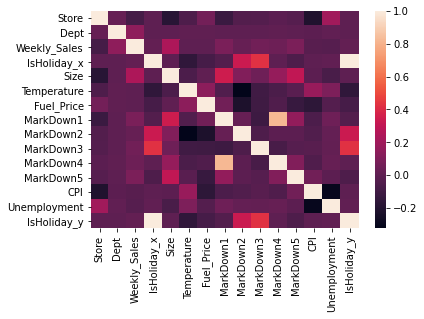

In [23]:
sns.heatmap(train.corr())

In [24]:
train.corr()

,Store,Dept,Weekly_Sales,IsHoliday_x,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday_y
Store,1.000000,0.024004,-0.085195,-0.000548,-0.182881,-0.050097,0.065290,-0.119588,-0.035173,-0.031556,-0.009941,-0.026634,-0.211088,0.208552,-0.000548
Dept,0.024004,1.000000,0.148032,0.000916,-0.002966,0.004437,0.003572,-0.002426,0.000290,0.001784,0.004257,0.000109,-0.007477,0.007837,0.000916
Weekly_Sales,-0.085195,0.148032,1.000000,0.012774,0.243828,-0.002312,-0.000120,0.085251,0.024130,0.060385,0.045414,0.090362,-0.020921,-0.025864,0.012774
IsHoliday_x,-0.000548,0.000916,0.012774,1.000000,0.000593,-0.155949,-0.078281,-0.035586,0.334818,0.427960,-0.000562,-0.053719,-0.001944,0.010460,1.000000
Size,-0.182881,-0.002966,0.243828,0.000593,1.000000,-0.058313,0.003361,0.345673,0.108827,0.048913,0.168196,0.304575,-0.003314,-0.068238,0.000593
Temperature,-0.050097,0.004437,-0.002312,-0.155949,-0.058313,1.000000,0.143859,-0.040594,-0.323927,-0.096880,-0.063947,-0.017544,0.182112,0.096730,-0.155949
Fuel_Price,0.065290,0.003572,-0.000120,-0.078281,0.003361,0.143859,1.000000,0.061371,-0.220895,-0.102092,-0.044986,-0.128065,-0.164210,-0.033853,-0.078281
MarkDown1,-0.119588,-0.002426,0.085251,-0.035586,0.345673,-0.040594,0.061371,1.000000,0.024486,-0.108115,0.819238,0.160257,-0.055558,0.050285,-0.035586
MarkDown2,-0.035173,0.000290,0.024130,0.334818,0.108827,-0.323927,-0.220895,0.024486,1.000000,-0.050108,-0.007768,-0.007440,-0.039534,0.020940,0.334818
MarkDown3,-0.031556,0.001784,0.060385,0.427960,0.048913,-0.096880,-0.102092,-0.108115,-0.050108,1.000000,-0.071095,-0.026467,-0.023590,0.012818,0.427960


Seems like Weekly sales does not have a high correlation to any of the other fields. The largest correlation is to Store size, with a value of less than 0.25